In [1]:
import os, sys, json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchvision import transforms

import editdistance

In [2]:
from datetime import datetime

DEVICE_NAME = 'cuda:2'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
MODEL_NAME = f'ocr_{now}'
MODEL_NAME

'ocr_2020-06-18--00-29-54'

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
PALETTE = sns.color_palette('pastel')

In [5]:
data_path = '../data/'
preproc_val_file = os.path.join(data_path, 'preproc_val.json')
preproc_train_file = os.path.join(data_path, 'preproc_train.json')
preproc_deduplicated_train_file = os.path.join(data_path, 'preproc_deduplicated_train.json')

test_pred_boxes_file = os.path.join(data_path, 'test_pred_boxes.json')

In [6]:
with open(preproc_val_file) as rf:
    preproc_val = json.load(rf)
len(preproc_val)

1000

In [7]:
with open(preproc_train_file) as rf:
    preproc_train = json.load(rf)
len(preproc_train)

24632

In [8]:
with open(preproc_deduplicated_train_file) as rf:
    preproc_deduplicated_train = json.load(rf)
len(preproc_deduplicated_train)

21800

# Датасет  OCR

In [9]:
PLATE_SIZE = (768, 256)
OUT_LEN = PLATE_SIZE[0]//32
BATCH_SIZE = 32
NUM_WORKERS = 24

In [10]:
ru_up_chars = 'АВЕКМНОРСТУХ'
ru_en_map = 'ABEKMHOPCTYX'
ru_en_translator = str.maketrans(ru_up_chars, ru_en_map)

def fix_text(text):
    text = text.upper()
    return text.translate(ru_en_translator)

In [11]:
alphabet = '0123456789ABEKMHOPCTYX'
print(len(alphabet))

def tokenize(text, start=1):
    return [alphabet.index(c) + start for c in text]

def to_text(tokens, start=1):
    return ''.join([alphabet[tk - start] for tk in tokens])

22


In [12]:
sample_num = 'A184XE38'
print(tokenize(sample_num))
assert sample_num == to_text(tokenize(sample_num))

[11, 2, 9, 5, 22, 13, 4, 9]


In [13]:
class OCRDataset(Dataset):
    def __init__(self, img_descriptors, transforms=None, data_path=data_path):
        self.marks = []
        for item in img_descriptors:
            fname = item['file']
            boxes = item['boxes']
            texts = item['texts'] if 'texts' in item else [None] * len(boxes)
            for box, text in zip(boxes, texts):                
                self.marks.append({
                    'file': fname,
                    'box': box,
                    'text': text,
                })

        self.data_path = data_path
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        fname = item['file']
        fpath = os.path.join(self.data_path, fname)
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        x_min, y_min, x_max, y_max = item['box']
        x_min = int(x_min)
        y_min = int(y_min)
        x_max = int(x_max) + 1
        y_max = int(y_max) + 1
        img = img[y_min:y_max, x_min:x_max]
        
        text, seq, seq_len = None, None, 0
        if 'text' in item and item['text'] is not None:
            text = item['text']
            seq = tokenize(text)
            seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'file': fname,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }        
        return output
    
    
    def __len__(self):
        return len(self.marks)

In [14]:
import glob
from torch.utils.data import ConcatDataset

class OCRGeneratedDataset(Dataset):
    def __init__(self, dir_name='generated_60k', dataset_len=None, transforms=None, data_path=data_path):
        file_paths = glob.glob(os.path.join(data_path, f'{dir_name}/*'))
        self.marks = []
        for file_path in file_paths:
            fname = os.path.split(file_path)[-1]
            text = fix_text(os.path.splitext(fname)[0])
            seq = tokenize(text)
            seq_len = len(seq)
            self.marks.append({
                'file': os.path.join(dir_name, fname),
                'text': text,
                'seq': seq,
                'seq_len': seq_len
            })
        self.real_len = len(self.marks)
        self.dataset_len = dataset_len or self.real_len
        self.data_path = data_path
        self.transforms = transforms
        
    def __getitem__(self, idx):
        while True:
            try:
                item = np.random.choice(self.marks)
                fname = item['file']
                fpath = os.path.join(self.data_path, fname)
                img = cv2.imread(fpath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                text = item['text']
                seq = item['seq']
                seq_len = item['seq_len']

                if self.transforms is not None:
                    img = self.transforms(img)

                output = {
                    'img': img,
                    'file': fname,
                    'text': text,
                    'seq': seq,
                    'seq_len': seq_len
                }        
                return output
            except:
                continue
    
    def __len__(self):
        return self.dataset_len

In [15]:
class Resize(object):
    def __init__(self, size=PLATE_SIZE):
        self.size = size

    def __call__(self, img):
        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img

In [16]:
class Rotate(object):
    def __init__(self, max_angle=15, fill_value=0.0, p=0.5):
        self.max_angle = max_angle
        self.fill_value = fill_value
        self.p = p

    def __call__(self, img):
        if np.random.uniform(0.0, 1.0) > self.p:
            return img
        img = img.copy()
        h, w, c = img.shape
        assert c == 3
        angle = np.random.uniform(-self.max_angle, self.max_angle)
        img = self.rotate_and_scale(img, angle=angle)
        return img

    def rotate_and_scale(self, image, scale_factor=1.0, angle=30):
        old_h, old_w = image.shape[:2]
        m = cv2.getRotationMatrix2D(center=(old_w / 2, old_h / 2), angle=angle, scale=scale_factor)

        new_w, new_h = old_w * scale_factor, old_h * scale_factor
        r = np.deg2rad(angle)
        sin_r = np.sin(r)
        cos_r = np.cos(r)
        new_w, new_h = (abs(sin_r * new_h) + abs(cos_r * new_w), abs(sin_r * new_w) + abs(cos_r * new_h))

        (tx, ty) = ((new_w - old_w) / 2, (new_h - old_h) / 2)
        m[0, 2] += tx
        m[1, 2] += ty
        rotated_img = cv2.warpAffine(image, m, dsize=(int(new_w), int(new_h)))
        return rotated_img

In [17]:
class Pad(object):
    def __init__(self, max_size=0.1, p=0.1):
        self.max_size = max_size
        self.p = p
        self.border_styles = ('replicate', 'zeroes', 'colour')

    def __call__(self, image):
        if np.random.uniform(0.0, 1.0) > self.p:
            return image
        image = image.copy()
        h, w, _ = image.shape
        
        top = int(np.random.uniform(0, self.max_size) * h)
        bottom = int(np.random.uniform(0, self.max_size) * h)
        left = int(np.random.uniform(0, self.max_size) * w)
        right = int(np.random.uniform(0, self.max_size) * w)
        border_style = np.random.choice(self.border_styles)
        
        if border_style == 'replicate':
            image = cv2.copyMakeBorder(image, top, bottom, left, right, borderType=cv2.BORDER_REPLICATE)
        else:
            value = np.random.uniform(size=(3,)) if border_style == 'colour' else 0.0  # zeroes
            image = cv2.copyMakeBorder(image, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=value)
        return image

In [18]:
class Album(object):
    def __init__(self, augs):
        self.augs = augs
        
    def __call__(self, image):
        for aug in self.augs:
            image = aug(image=image)['image']
        return image

In [19]:
from albumentations import GlassBlur, GaussNoise

train_ocr_transforms = transforms.Compose([
    Rotate(),
    Pad(),
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

val_ocr_transforms = transforms.Compose([
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

generated_ocr_transforms = transforms.Compose([
    Album([GlassBlur(sigma=2, max_delta=2), GaussNoise()]),
    Rotate(max_angle=20),
    Pad(max_size=0.4, p=0.25),
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

In [20]:
train_ocr_dataset = OCRDataset(
    preproc_train,
    transforms=train_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    preproc_val,
    transforms=val_ocr_transforms
)
generated_ocr_dataset = OCRGeneratedDataset(
    transforms=generated_ocr_transforms,
    dataset_len=10000
)

In [21]:
combined_train_dataset = ConcatDataset([train_ocr_dataset, generated_ocr_dataset])

In [22]:
def collate_fn_ocr(batch):
    images, seqs, seq_lens, texts, files = [], [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"] or [])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"] if "text" in sample else None)
        files.append(sample["file"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts, "file": files}
    return batch

In [23]:
train_ocr_loader = DataLoader(
    combined_train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=True
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=False
)

In [24]:
def show_sample(sample):
    fig = plt.figure(figsize=(14,10))
    img = sample['img'].permute(1,2,0).numpy()
    text = sample['text']
    print(text)
    plt.imshow(img)

In [25]:
val_ocr_dataset[0]['img'].shape

torch.Size([3, 256, 768])

E750AB35


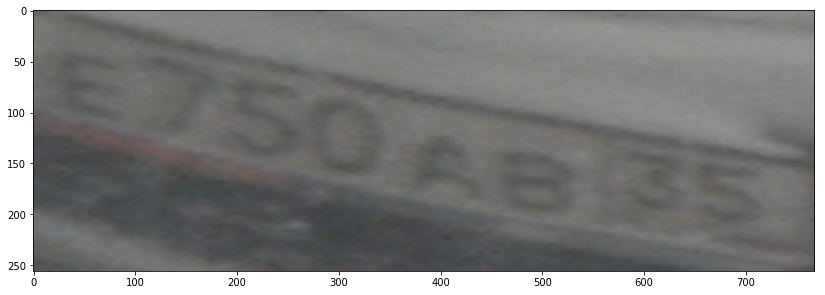

In [26]:
show_sample(val_ocr_dataset[10])

H463BX161


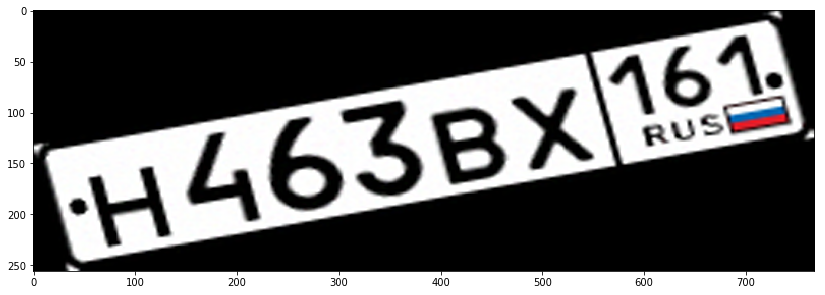

In [27]:
show_sample(combined_train_dataset[-1])

# Модель OCR

In [28]:
device = torch.device(DEVICE_NAME) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=2)

In [29]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=OUT_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

    
class TransformerDecoder(nn.Module):
    def __init__(self, output_dim, hid_dim, dim_ff, n_heads, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        self.pos_encoder = PositionalEncoding(hid_dim, dropout)
        decoder_layers = nn.TransformerDecoderLayer(hid_dim, n_heads, dim_ff, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, n_layers)
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim,
            bias=False
        )
        
    def forward(self, input, encoder_outputs, key_padding_mask=None):        
        # input = [src len, batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]
        
        embedded = self.pos_encoder(input * np.sqrt(self.hid_dim)) # [src len, batch size, hid dim]
        
        # [src len, batch size, hid dim]
        outputs = self.transformer_decoder(embedded, encoder_outputs, tgt_key_padding_mask=key_padding_mask)
        
        output = self.out(outputs) # [src len, batch size, output dim]
        return output

In [30]:
class RecognitionModel(nn.Module):
    def __init__(self,
                    input_size=PLATE_SIZE,
                    dropout=0.1,
                    num_classes=len(alphabet)+1,
                    hid_dim=512,
                    dim_ff=512,
                    n_heads=4,
                    n_layers=4):
        super(RecognitionModel, self).__init__()
        self.num_classes = num_classes
        self.hid_dim = hid_dim

        resnet = getattr(models, 'resnet34')(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.num_backbone_features = self.get_block_size(self.backbone)
        
        self.channel_projector = nn.Conv2d(self.num_backbone_features, self.hid_dim, kernel_size=1)
        self.height_projector = nn.Conv2d(input_size[1] // 32, 1, kernel_size=1)

        self.decoder = TransformerDecoder(output_dim=self.num_classes,
                                            hid_dim=self.hid_dim,
                                            dim_ff=dim_ff,
                                            n_heads=n_heads,
                                            n_layers=n_layers,
                                            dropout=dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x, decode=False):
        
        # features = [b, c, h, w]
        features = self.backbone(x)
        
        # features = [b, c, h, w]
        features = self.channel_projector(features)
        
        # features_sequence = [w, b, c]
        features_sequence = self.features_to_sequence(features)
        
        # out_sequence = [w, b, c]
        out_sequence = self.decoder(features_sequence, features_sequence)

        if not self.training:
            out_sequence = self.softmax(out_sequence)
            if decode:
                out_sequence = self.decode(out_sequence)

        return out_sequence

    def features_to_sequence(self, features):
        # features = [b, c, h, w]        
        features = features.permute(0, 2, 1, 3).contiguous() # [b, h, c, w]
        features = self.height_projector(features) # [b, h'=1, c, w]
        features = features.squeeze(1).permute(2, 0, 1).contiguous() # [w, b, c]
        return features

    def get_block_size(self, layer):
        return list(layer[-1][-1].children())[-2].weight.size()[0]

    def pred_to_string(self, pred):
        seq = []
        for i in range(len(pred)):
            label = np.argmax(pred[i])
            seq.append(label)
        out = []
        for i in range(len(seq)):
            if len(out) == 0:
                if seq[i] != 0:
                    out.append(seq[i])
            else:
                if seq[i] != 0 and seq[i] != seq[i - 1]:
                    out.append(seq[i])
        out = to_text(out)
        return out

    def decode(self, pred):
        pred = pred.permute(1, 0, 2).cpu().data.numpy()
        outputs = []
        for i in range(len(pred)):
            outputs.append(self.pred_to_string(pred[i]))
        return outputs

In [31]:
@torch.no_grad()
def evaluate(model, iterator, with_tqdm=True):    
    model.eval()
    count, tp, avg_ed = 0, 0, 0
    if with_tqdm:
        iterator = tqdm(iterator, total=len(iterator), leave=True, position=0, desc='batch')
    for batch in iterator:
        images = batch['image'].to(device)
        target_texts = batch['text']
        predictions = model(images, decode=True)        
        for target, pred in zip(target_texts, predictions):
            if target == pred:
                tp += 1
            else:
                avg_ed += editdistance.eval(pred, target)
            count += 1
    acc = tp / count
    avg_ed = avg_ed / count    
    return acc, avg_ed

In [32]:
from torch.nn.functional import ctc_loss, log_softmax

def train(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, epochs=10):
    # TODO: try different techniques for fighting overfitting of the trained modelwork
    best_val_ed = float('inf')
    best_val_acc = -1
    for e in range(epochs):
        print('Starting epoch {}/{}.'.format(e + 1, epochs))
        
        model.train()
            
        loss_mean = []
        train_iter = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True, position=0, desc='batch')
        for j, batch in train_iter:
            optimizer.zero_grad()
            images = batch['image'].to(device)
            seqs = batch['seq']
            seq_lens = batch['seq_len']
            
            seqs_pred = model(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
            # TODO: ctc_loss is not an only choice here
            loss = criterion(log_probs, seqs, seq_lens_pred, seq_lens)
            loss.backward()
            loss_mean.append(loss.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer.step()
            
        print('Epoch finished! Loss: {:.5f}'.format(np.mean(loss_mean)))

        model.eval()
        acc_val, ed_val = evaluate(model, val_dataloader)
        if scheduler is not None:
            scheduler.step(ed_val)

        if ed_val < best_val_ed:
            best_val_ed = ed_val
            best_val_acc = acc_val
            torch.save(model.state_dict(), f'models/{MODEL_NAME}.pth')
            print('Valid acc: {:.5f}, valid ed: {:.5f} (best)'.format(acc_val, ed_val))
        else:
            print('Valid acc: {:.5f}, valid ed: {:.5f} (best {:.5f}, {:.5f})'.format(
                acc_val, ed_val, best_val_acc, best_val_ed))
    print('Best valid acc: {:.5f}, best val ed: {:.5f}'.format(best_val_acc, best_val_ed))

In [33]:
model = RecognitionModel()
model.to(device);

In [34]:
criterion = ctc_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

In [35]:
train(model, criterion, optimizer, scheduler, train_ocr_loader, val_ocr_loader, epochs=50)

Starting epoch 1/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.45105


batch: 100%|██████████| 35/35 [00:10<00:00,  3.19it/s]


Valid acc: 0.85178, valid ed: 0.21958 (best)
Starting epoch 2/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.14076


batch: 100%|██████████| 35/35 [00:11<00:00,  3.13it/s]


Valid acc: 0.88289, valid ed: 0.20220 (best)
Starting epoch 3/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.12975


batch: 100%|██████████| 35/35 [00:11<00:00,  3.18it/s]


Valid acc: 0.92223, valid ed: 0.11802 (best)
Starting epoch 4/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.11295


batch: 100%|██████████| 35/35 [00:10<00:00,  3.28it/s]


Valid acc: 0.93321, valid ed: 0.10247 (best)
Starting epoch 5/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.09643


batch: 100%|██████████| 35/35 [00:11<00:00,  3.16it/s]


Valid acc: 0.94236, valid ed: 0.08509 (best)
Starting epoch 6/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.09469


batch: 100%|██████████| 35/35 [00:12<00:00,  2.86it/s]

Valid acc: 0.93413, valid ed: 0.09332 (best 0.94236, 0.08509)
Starting epoch 7/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.08607


batch: 100%|██████████| 35/35 [00:10<00:00,  3.18it/s]


Valid acc: 0.94145, valid ed: 0.08234 (best)
Starting epoch 8/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.08096


batch: 100%|██████████| 35/35 [00:10<00:00,  3.36it/s]


Valid acc: 0.94876, valid ed: 0.07502 (best)
Starting epoch 9/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.08070


batch: 100%|██████████| 35/35 [00:10<00:00,  3.45it/s]

Valid acc: 0.94694, valid ed: 0.07685 (best 0.94876, 0.07502)
Starting epoch 10/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.07863


batch: 100%|██████████| 35/35 [00:12<00:00,  2.85it/s]

Valid acc: 0.94602, valid ed: 0.07594 (best 0.94876, 0.07502)
Starting epoch 11/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.07304


batch: 100%|██████████| 35/35 [00:13<00:00,  2.54it/s]

Valid acc: 0.94419, valid ed: 0.08234 (best 0.94876, 0.07502)
Starting epoch 12/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.07385


batch: 100%|██████████| 35/35 [00:11<00:00,  3.16it/s]

Epoch    12: reducing learning rate of group 0 to 1.5000e-04.
Valid acc: 0.93962, valid ed: 0.08783 (best 0.94876, 0.07502)
Starting epoch 13/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.07110


batch: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Valid acc: 0.95242, valid ed: 0.06130 (best)
Starting epoch 14/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06832


batch: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]

Valid acc: 0.94876, valid ed: 0.07136 (best 0.95242, 0.06130)
Starting epoch 15/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06579


batch: 100%|██████████| 35/35 [00:11<00:00,  3.16it/s]


Valid acc: 0.96066, valid ed: 0.05581 (best)
Starting epoch 16/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06208


batch: 100%|██████████| 35/35 [00:10<00:00,  3.20it/s]

Valid acc: 0.95700, valid ed: 0.05855 (best 0.96066, 0.05581)
Starting epoch 17/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06702


batch: 100%|██████████| 35/35 [00:11<00:00,  2.99it/s]

Valid acc: 0.95608, valid ed: 0.06221 (best 0.96066, 0.05581)
Starting epoch 18/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06146


batch: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]

Valid acc: 0.95974, valid ed: 0.05672 (best 0.96066, 0.05581)
Starting epoch 19/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06357


batch: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]

Epoch    19: reducing learning rate of group 0 to 7.5000e-05.
Valid acc: 0.95883, valid ed: 0.06038 (best 0.96066, 0.05581)
Starting epoch 20/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06552


batch: 100%|██████████| 35/35 [00:11<00:00,  3.09it/s]

Valid acc: 0.95883, valid ed: 0.05947 (best 0.96066, 0.05581)
Starting epoch 21/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06401


batch: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]


Valid acc: 0.95974, valid ed: 0.05489 (best)
Starting epoch 22/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05922


batch: 100%|██████████| 35/35 [00:11<00:00,  3.13it/s]

Valid acc: 0.95974, valid ed: 0.05489 (best 0.95974, 0.05489)
Starting epoch 23/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06062


batch: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]

Valid acc: 0.95883, valid ed: 0.05489 (best 0.95974, 0.05489)
Starting epoch 24/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06098


batch: 100%|██████████| 35/35 [00:11<00:00,  3.15it/s]

Valid acc: 0.95791, valid ed: 0.05855 (best 0.95974, 0.05489)
Starting epoch 25/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05990


batch: 100%|██████████| 35/35 [00:10<00:00,  3.29it/s]

Epoch    25: reducing learning rate of group 0 to 3.7500e-05.
Valid acc: 0.95883, valid ed: 0.05672 (best 0.95974, 0.05489)
Starting epoch 26/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05236


batch: 100%|██████████| 35/35 [00:10<00:00,  3.18it/s]


Valid acc: 0.96157, valid ed: 0.05215 (best)
Starting epoch 27/50.


batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.06058


batch: 100%|██████████| 35/35 [00:11<00:00,  3.11it/s]

Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 28/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05342


batch: 100%|██████████| 35/35 [00:11<00:00,  3.17it/s]

Valid acc: 0.95791, valid ed: 0.05489 (best 0.96157, 0.05215)
Starting epoch 29/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05636


batch: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]

Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 30/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05619


batch: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]

Epoch    30: reducing learning rate of group 0 to 1.8750e-05.
Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 31/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05535


batch: 100%|██████████| 35/35 [00:11<00:00,  2.98it/s]

Valid acc: 0.95883, valid ed: 0.05306 (best 0.96157, 0.05215)
Starting epoch 32/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05592


batch: 100%|██████████| 35/35 [00:12<00:00,  2.81it/s]

Valid acc: 0.95974, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 33/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05704


batch: 100%|██████████| 35/35 [00:12<00:00,  2.82it/s]

Valid acc: 0.95791, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 34/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05009


batch: 100%|██████████| 35/35 [00:11<00:00,  3.15it/s]

Epoch    34: reducing learning rate of group 0 to 9.3750e-06.
Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 35/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.04944


batch: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]

Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 36/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05385


batch: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s]

Valid acc: 0.95883, valid ed: 0.05489 (best 0.96157, 0.05215)
Starting epoch 37/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05256


batch: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]

Valid acc: 0.95974, valid ed: 0.05489 (best 0.96157, 0.05215)
Starting epoch 38/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05514


batch: 100%|██████████| 35/35 [00:11<00:00,  3.03it/s]

Epoch    38: reducing learning rate of group 0 to 4.6875e-06.
Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 39/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05255


batch: 100%|██████████| 35/35 [00:12<00:00,  2.88it/s]

Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 40/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05571


batch: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s]

Valid acc: 0.96066, valid ed: 0.05306 (best 0.96157, 0.05215)
Starting epoch 41/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05612


batch: 100%|██████████| 35/35 [00:11<00:00,  3.08it/s]

Valid acc: 0.95791, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 42/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05296


batch: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]

Epoch    42: reducing learning rate of group 0 to 2.3437e-06.
Valid acc: 0.95883, valid ed: 0.05489 (best 0.96157, 0.05215)
Starting epoch 43/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05068


batch: 100%|██████████| 35/35 [00:11<00:00,  3.13it/s]

Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Starting epoch 44/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05347


batch: 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]

Valid acc: 0.95883, valid ed: 0.05489 (best 0.96157, 0.05215)
Starting epoch 45/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05559


batch: 100%|██████████| 35/35 [00:11<00:00,  3.01it/s]

Valid acc: 0.96066, valid ed: 0.05306 (best 0.96157, 0.05215)
Starting epoch 46/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05468


batch: 100%|██████████| 35/35 [00:11<00:00,  2.94it/s]

Epoch    46: reducing learning rate of group 0 to 1.1719e-06.
Valid acc: 0.95791, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 47/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.04870


batch: 100%|██████████| 35/35 [00:12<00:00,  2.73it/s]

Valid acc: 0.95791, valid ed: 0.05672 (best 0.96157, 0.05215)
Starting epoch 48/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05638


batch: 100%|██████████| 35/35 [00:12<00:00,  2.85it/s]

Valid acc: 0.95791, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 49/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05480


batch: 100%|██████████| 35/35 [00:11<00:00,  3.10it/s]

Valid acc: 0.95791, valid ed: 0.05581 (best 0.96157, 0.05215)
Starting epoch 50/50.



batch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch finished! Loss: 0.05137


batch: 100%|██████████| 35/35 [00:11<00:00,  2.98it/s]

Epoch    50: reducing learning rate of group 0 to 5.8594e-07.
Valid acc: 0.95974, valid ed: 0.05398 (best 0.96157, 0.05215)
Best valid acc: 0.96157, best val ed: 0.05215


In [36]:
with open(f'models/{MODEL_NAME}.pth', "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

# Submit

In [37]:
with open(test_pred_boxes_file) as rf:
    test_pred_boxes = json.load(rf)
len(test_pred_boxes)

3188

In [38]:
sample_submit = pd.read_csv(os.path.join(data_path, 'submission.csv'))

In [39]:
test_ocr_dataset = OCRDataset(
    test_pred_boxes,
    transforms=val_ocr_transforms
)

In [40]:
test_ocr_loader = DataLoader(
    test_ocr_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=False
)

In [41]:
@torch.no_grad()
def make_submit(model, test_loader, with_tqdm=True, sample_submit=sample_submit):    
    model.eval()
    
    submit = sample_submit.copy()
    submit.drop('plates_string', axis=1, inplace=True)
    results = {}
    
    if with_tqdm:
        iterator = tqdm(test_loader, total=len(test_loader), leave=True, position=0, desc='batch')
    for batch in iterator:
        fnames = batch['file']
        images = batch['image'].to(device)
        predictions = model(images, decode=True)        
        for fname, pred in zip(fnames, predictions):
            if fname in results:
                results[fname] += ' ' + pred
            else:
                results[fname] = pred
    
    results = [{'file_name': fname, 'plates_string': pred} for (fname, pred) in results.items()]
    results = pd.DataFrame.from_records(results)
    submit = submit.merge(results, on='file_name', how='left')
    submit.plates_string.fillna('', inplace=True)
    return submit

In [42]:
submit = make_submit(model, test_ocr_loader)

batch: 100%|██████████| 111/111 [00:27<00:00,  6.91it/s]


In [43]:
submit.head()

,file_name,plates_string
0,test/0.jpg,O195KC96
1,test/1.jpg,O001OO24 O005OO24
2,test/2.jpg,H030MB33
3,test/3.jpg,A852TO21 C139AP96 H535KK55
4,test/4.bmp,B955ET35


In [44]:
submit.to_csv(f'submits/submit_{MODEL_NAME}.csv', index=False)

In [45]:
def show_sample(index, df, data_path=data_path):
    fig = plt.figure(figsize=(14,10))
    fname = df.at[index, 'file']
    pred_text = df.at[index, 'plate']
    fname = os.path.join(data_path, fname)
    print(f'File: {fname}')
    print(f'Predicted: {pred_text}')
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [46]:
plates = pd.DataFrame.from_records([dict(file=file, plate=plate)
                                for (file, plates) in zip(submit.file_name, submit.plates_string.str.split())
                                for plate in plates])

In [47]:
plates['plate_len'] = plates.plate.str.len()

In [48]:
plates.plate_len.value_counts()

8     2637
9      893
7       16
10       2
6        1
4        1
Name: plate_len, dtype: int64

In [59]:
plates[plates.plate_len == 7]

,file,plate,plate_len
117,test/102.png,E0542MM,7
541,test/485.jpg,P274AB9,7
676,test/609.jpg,X751CA3,7
755,test/684.jpg,2277T32,7
1104,test/993.jpg,T164MY0,7
1458,test/1310.jpg,740PB54,7
1546,test/1390.jpg,AAA7197,7
1597,test/1438.jpg,Y843YT5,7
1831,test/1640.jpg,P001MH4,7
1871,test/1676.jpg,103ME69,7


File: ../data/test/2112.bmp
Predicted: O7KX355


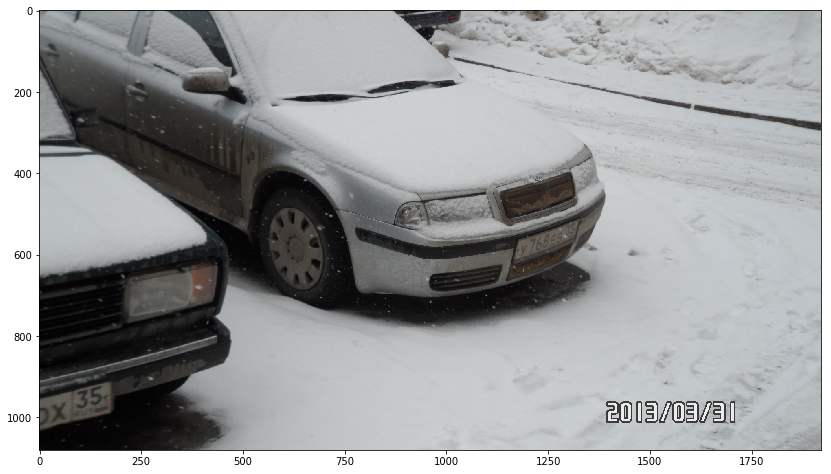

In [73]:
show_sample(2353, plates)